Modification du réseau précédent pour augementer le nombre de canaux de sortie de la première couche. Le but est de prendre en compte plus de traits caractérisques de nos images d'entrée.

In [10]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0] # Nombre de ligne de la matrice x_train
test_size  = x_test.shape[0]

In [12]:
#Nombre d'époques pour l'apprentissage:
n_epoch = 15

# Taille du batch d'entraînement:
batch_size = 100

# Incrément pour l'apprentissage
starter_learning_rate = 0.003
# taux de décroissance du pas d'apprentissage
decay_rate = 0.7
# Nombre d'époques à faire avant de changer de pas
decay_epoch = 3

In [13]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
Xd = tf.reshape(X, [-1,28,28,1])


W1 = tf.Variable(tf.truncated_normal([6,6,1,12], stddev=0.1))
b1 = tf.Variable(tf.ones([12])/10)
stride1 = 1
Y1cnv = tf.nn.conv2d(Xd, W1, strides=[1, stride1, stride1, 1], padding='SAME')
Y1 = tf.nn.relu(Y1cnv + b1)

W2 = tf.Variable(tf.truncated_normal([5,5,12,12], stddev=0.1))
b2 = tf.Variable(tf.ones([12])/10)
stride2 = 2
Y2cnv = tf.nn.conv2d(Y1, W2, strides=[1,stride2,stride2,1], padding='SAME')
Y2 = tf.nn.relu(Y2cnv + b2)

W3 = tf.Variable(tf.truncated_normal([4,4,12,24], stddev=0.1))
b3 = tf.Variable(tf.ones([24])/10)
stride3 = 2
Y3cnv = tf.nn.conv2d(Y2, W3, strides=[1,stride3,stride3,1], padding='SAME')
Y3 = tf.nn.relu(Y3cnv + b3)

Y3d = tf.reshape(Y3, [-1, 7*7*24])

# dropout_rate: probabilité qu'un neurone soit supprimé (doit être = 0 lors de la phase de test)
dropout_rate = tf.placeholder(tf.float32)
W4 = tf.Variable(tf.truncated_normal([7*7*24,200], stddev=0.1))
b4 = tf.Variable(tf.ones([200])/10)
Y4 = tf.nn.relu(tf.matmul(Y3d,W4) + b4)
Y4d = tf.nn.dropout(Y4, rate=dropout_rate)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
b5 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Y4d,W5) + b5
Y = tf.nn.softmax(Ylogits)

In [14]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_epoch*train_size//batch_size, decay_rate, staircase=True)

# Optimisation
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

In [15]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

In [16]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_, dropout_rate:0.25}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss  = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        test_data = {X: x_test, Y_: y_test, dropout_rate:0}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  

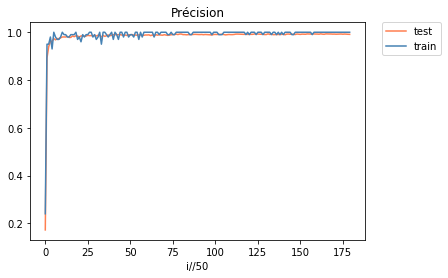

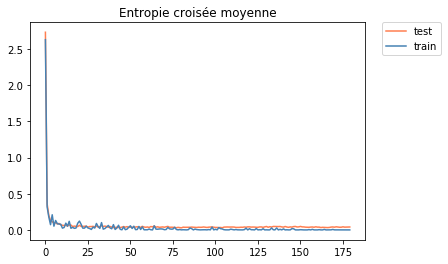

Best score for iteration 6550 	| Accuracy = 0.9933


In [17]:
# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

In [9]:
sess.close()

Best score for iteration 6550 	| Accuracy = 0.9933

99.33 % de taux de reconnaissance sur le jeu de test. Mission réussie :)